In [11]:
from scipy import ndimage
import matplotlib.pyplot as plt
def show(img, interpolation=None, axis=None):
  '''
  Displays an image with or without a color channel,
  '''
  cmap = 'gray' if len(img.shape) == 2 else None
  a = plt if axis is None else axis
  a.imshow(img, interpolation=interpolation, cmap=cmap)  # Draw image
  a.axis('off')  # We're not interested in image position here
  plt.tight_layout()
  if axis is None:
    plt.show()  # Show image
    
from PIL import Image
import requests
from io import BytesIO
def load_from_url(url):
  '''
  Loads and returns an image from the internet,
  using the provided URL
  '''
  response = requests.get(url)
  return np.asarray(Image.open(BytesIO(response.content)))    

# Peak Detection

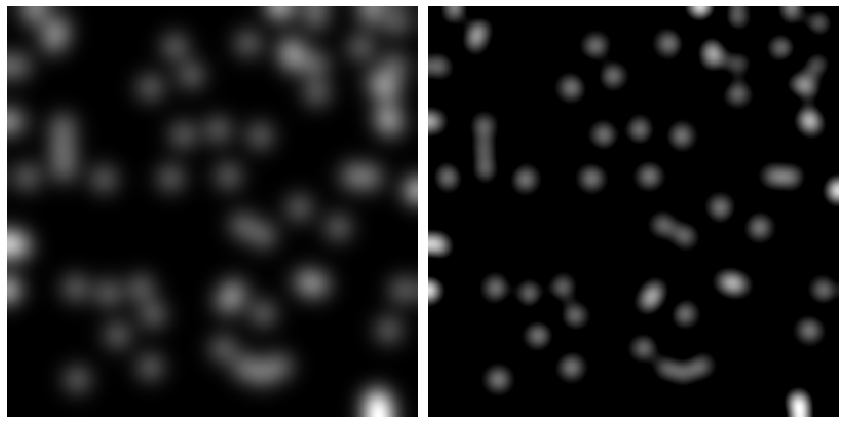

In [12]:
# Number of blobs
n = 64

# Size of image
l = 400
blob_img = np.zeros((l, l))

# Generate ranom points
np.random.seed(1)
points = l*np.random.random((2, n))

# Draw points on the image
blob_img[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1

# Smooth them out with a Gaussian
blob_img = ndimage.gaussian_filter(blob_img, 12)

fig, ax = plt.subplots(1, 2, figsize=(12,6))

show(blob_img, axis=ax[0])

# DoG with clipping at min zero
# Since we know that the original image is distorted with a gaussian all ready
# we only need to subtract a Gaussian with a smaller variance
sblob_img = np.clip(blob_img - ndimage.gaussian_filter(blob_img, 1), 0, None)
show(sblob_img, axis=ax[1])
plt.tight_layout()

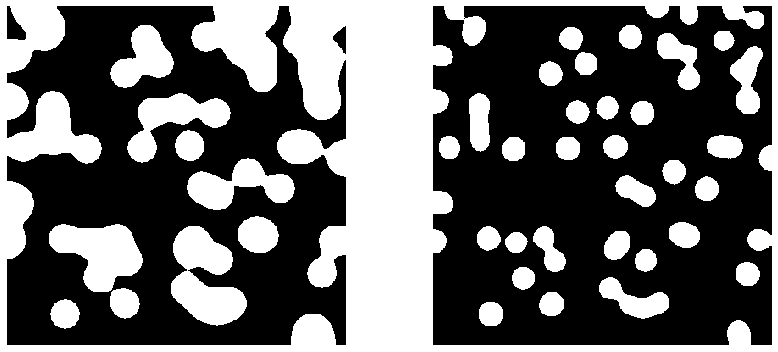

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

mask = (blob_img > blob_img.mean()).astype(np.float)
show(mask, axis=ax1)
mask = (sblob_img > sblob_img.mean()).astype(np.float)
show(mask, axis=ax2)

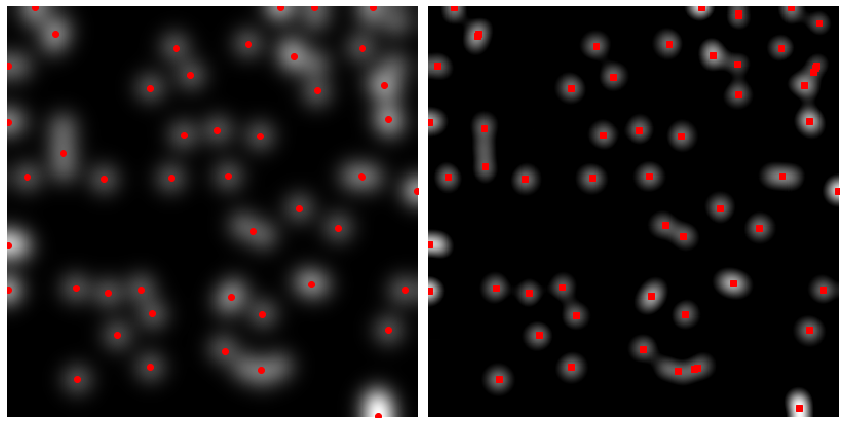

In [14]:
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure
import matplotlib.pyplot as pp

def detect_peaks(image):
  """
  Takes an image and detect the peaks usingthe local maximum filter.
  Returns two list of peak x and y coordinates.
  """

  # Define an 8-connected neighborhood
  neighborhood = generate_binary_structure(2,2)

  # Apply the local maximum filter; all pixel of maximal value 
  # in their neighborhood are set to 1
  local_max = maximum_filter(image, footprint=neighborhood)==image
  # Local_max is a mask that contains the peaks we are 
  # looking for, but also the background.
  
  # In order to isolate the peaks we must remove the background from the mask.
  detected_peaks = np.logical_and(local_max, image > np.mean(image))

  # Get peak coordinates
  coords = np.argwhere(detected_peaks)
  
  return coords[:, 1], coords[:, 0]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

show(blob_img, axis=ax1)
x, y = detect_peaks(blob_img)
ax1.plot(x, y, 'ro')

show(sblob_img, axis=ax2)
x, y = detect_peaks(sblob_img)
ax2.plot(x, y, 'rs')

plt.show()

# Blob Detection

In [15]:
from skimage.feature import blob_dog, blob_log, blob_doh

def plot_blobs(blobs, axis):
  '''
  Draws circles around blobs
  '''
  for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    axis.add_patch(c)

(360, 640, 3)


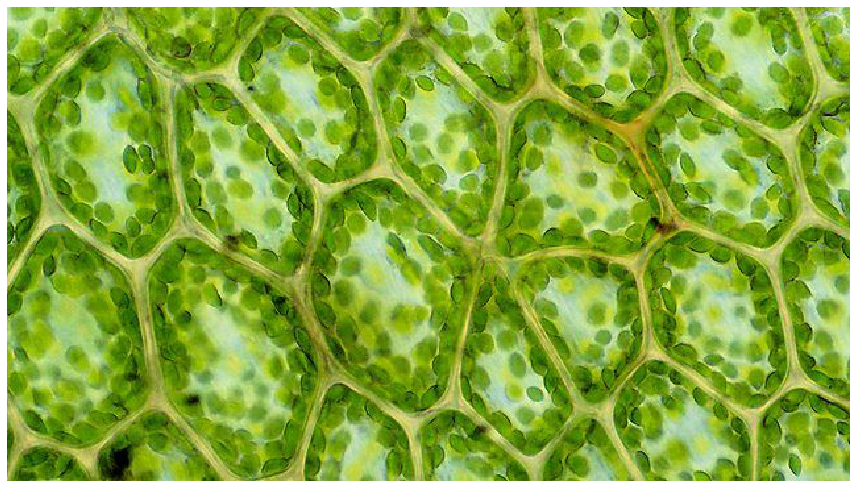

In [16]:
URL = 'https://i.pinimg.com/originals/09/fb/bb/09fbbbfef10bbeaf006626bc942a6626.jpg'
img2 = load_from_url(URL)
gimg2 = np.mean(img2, axis=2)

print(img2.shape)
fig, ax = plt.subplots(1, figsize=(12, 7))
show(img2)

In [17]:
# Laplacian of Gaussian (LoG)
# min_sigma: Keep this low to detect smaller blobs.
# max_sigma: Keep this high to detect larger blobs
# num_sigma: Sampling between min_sigma and max_sigma.
# threshold: Reduce this to detect blobs with less intensities.
# overlap: Maximum area fraction overlap for discarding smalles blob
blobs = blob_log(gimg2, min_sigma=30, max_sigma=30, num_sigma=1, threshold=.1)
blobs[:, 2] = blobs[:, 2] * np.sqrt(2)  # Blob radii
print("Number of blobs detected:", len(blobs))

Number of blobs detected: 26


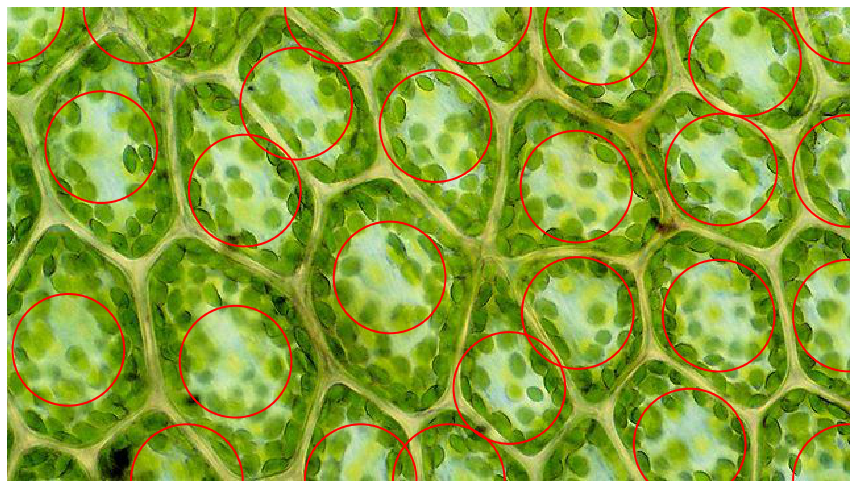

In [18]:
fig, ax = plt.subplots(1, figsize=(12, 7))
show(img2, axis=ax)
plot_blobs(blobs, ax)
plt.show()

(375, 375, 3)


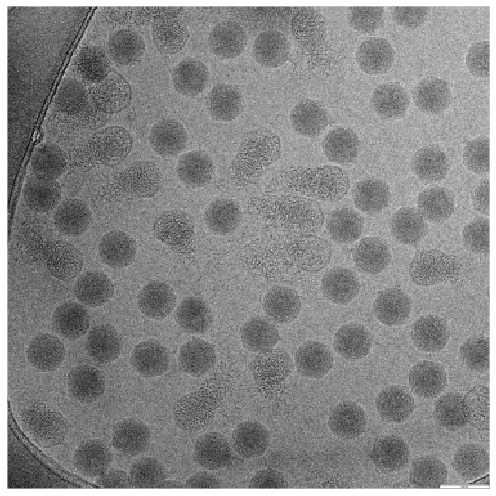

In [19]:
URL = 'https://www.gatan.com/sites/default/files/styles/375w/public/Cryo-EM%20images%20of%20T7%20phage_0.jpg'
img3 = load_from_url(URL)
gimg3 = np.mean(img3, axis=2)

print(img3.shape)
fig, ax = plt.subplots(1, figsize=(7, 7))
show(img3)

In [20]:
# Difference of Gaussian (DoG)
blobs = blob_dog(gimg3, min_sigma=10, max_sigma=10, threshold=60)
blobs[:, 2] = blobs[:, 2] * np.sqrt(2)  # Blob radii
print("Number of blobs detected:", len(blobs))

# We need to invert the image to find peaks
blobs_inv = blob_dog(gimg3 *-1, min_sigma=10, max_sigma=10, threshold=80)
blobs_inv[:, 2] = blobs_inv[:, 2] * np.sqrt(2)  # Blob radii
print("Number of blobs detected:", len(blobs_inv))

Number of blobs detected: 12
Number of blobs detected: 34


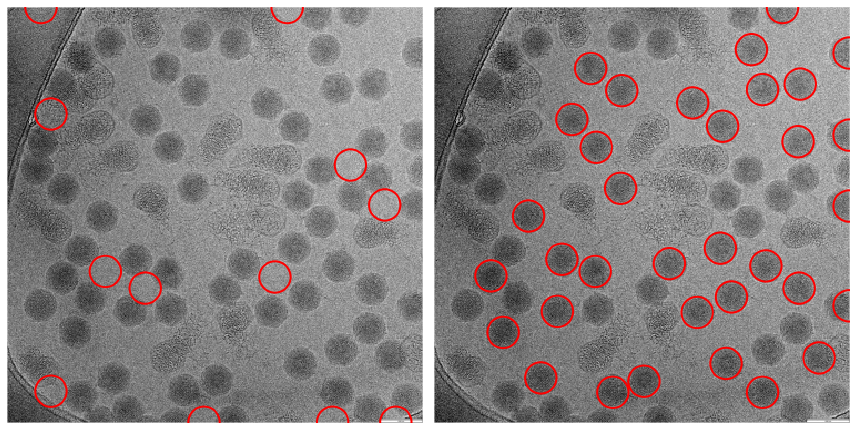

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

show(img3, axis=ax[0])
plot_blobs(blobs, ax[0])

show(gimg3, axis=ax[1])
plot_blobs(blobs_inv, ax[1])

plt.show()